In [5]:
import numpy as np 
import pandas as pd
import allel
import malariagen_data
%matplotlib inline
import sys
# adding Folder_2 to the system path
sys.path.insert(0, '/home/sanj/projects/gaardian/workflow/scripts/')
import probetools as probe
%run hapclust.py

In [6]:
def load_metahaps(cohorts, names, metaquery = "aim_species == 'gambiae'"):
    meta = ag3.sample_metadata(cohorts)
    meta = meta.query("sample_id in @names")
    meta.loc[:, 'sample_id'] = pd.Categorical(meta['sample_id'], categories = names, ordered = True)
    if metaquery != None: 
        query_bool = meta.eval(metaquery)
        meta = meta.query(metaquery)
    meta = meta.sort_values(by='sample_id')
    metahaps = pd.DataFrame(np.repeat(meta.values, 2, axis=0))
    metahaps.columns = meta.columns
    return(metahaps, query_bool)

def check_order(meta, order, col='sample_id'):
    assert meta[col].to_list() == order, "Order of metadata is incorrect"
    print("correct order")
    
    
def plot_snps(transcript, data, cohorts, width=1500, height=600, palette='Category10', sample_set="sample_set"):

    # hover tooltips
    tooltips = [
        ("position", '@contig:@position{,}'),
        ("alleles", '@ref_allele>@alt_allele'),
        ("pass", "@pass_gamb_colu_arab, @pass_gamb_colu, @pass_arab"),
        ("impact", '@impact'),
        ("effect", '@effect'),
        ("aa_change", '@aa_change'),
        ("frequency", '@frequency{%f} (@cohort)'),
        ("freqdiff from wildtype", '@freq_diff_from_wt{%f}'),
    ]

    fig1 = bokeh.plotting.figure(
        title=f'Transcript - {transcript}',
        tools='xpan,xzoom_in,xzoom_out,xwheel_zoom,reset,hover',
        active_scroll='xwheel_zoom',
        active_drag='xpan',
        plot_width=width, 
        plot_height=height, 
        tooltips=tooltips,
        toolbar_location="above")

    # set up colors
    palette = bokeh.palettes.all_palettes[palette]
    colors = palette[len(cohorts)] if len(cohorts) > 2 else palette[3]
    
    # plot allele frequencies
    for coh, color in zip(cohorts, colors):
        df = data.copy()
        # add X coordinate in Mbp
        df['x'] = df['position'] / 1e6
        df['frequency'] = df[coh]
        df['cohort'] = coh
        df['freq_diff_from_wt'] = data[f"{coh} | freqdiff"] if "wt" not in coh else 0 
        diffdf = df.query("freq_diff_from_wt > 0.4")
        df = df.query("freq_diff_from_wt < 0.4")
        fig1.triangle("x", coh, 
                      size=8, 
                      color=color,
                      source=df,
                      legend_label=coh)
        fig1.circle("x", coh, 
                    size=10, color=color, 
                    source=diffdf,
                    legend_label=coh)

    # tidy up the plot
    fig1.y_range = bokeh.models.Range1d(-0.05, 1.1)
    fig1.yaxis.axis_label = f'Alt allele frequency'
    fig1.xaxis.visible = False
    fig1.add_layout(fig1.legend[0], 'right')
    fig1.legend.click_policy="hide"

    # plot transcript
    fig2 = plot_transcript(transcript, width=width, height=80, show=False, 
                           x_range=fig1.x_range)
    fig2.toolbar.logo = None 
    fig2.toolbar_location = None
    fig2.title = None #sample_set

    bokeh.plotting.show(bokeh.layouts.column(fig1, fig2))
    
def plot_transcript(transcript, width=700, height=120, show=True, x_range=None,
                    toolbar_location='above'):

    # find the gene
    df_geneset = ag3.geneset().set_index("ID")
    parent  = df_geneset.loc[transcript]

    # define tooltips for hover
    tooltips = [
        ("Type", '@type'),
        ("Location", '@contig:@start{,}..@end{,}'),
    ]

    # make a figure
    fig = bokeh.plotting.figure(
        title=f'Transcript - {transcript} ({parent.strand})',
        plot_width=width, 
        plot_height=height,
        tools='xpan,xzoom_in,xzoom_out,xwheel_zoom,reset,hover',
        toolbar_location=toolbar_location,
        active_scroll='xwheel_zoom',
        active_drag='xpan',
        tooltips=tooltips,
        x_range=x_range,
    )

    # find child components of the transcript
    data = df_geneset.query(f"Parent == '{transcript}'").copy()
    data['left'] = data['start'] / 1e6  # plot in Mbp coordinates
    data['right'] = data['end'] / 1e6  # plot in Mbp coordinates
    data['bottom'] = -0.4
    data['top'] = 0.4

    # plot exons
    exons = data.query("type == 'exon'")
    fig.quad(bottom='bottom', top='top', left='left', right='right',
             source=exons, fill_color=None, line_color='black', line_width=.5, 
             fill_alpha=0)
    
    # plot introns
    for l, r in zip(exons[:-1]['right'], exons[1:]['left']):
        m = (l + r) / 2
        fig.line([l, m, r], [0, .1, 0], line_width=1, line_color="black")

    # plot UTRs
    fig.quad(bottom='bottom', top='top', left='left', right='right',
                source=data.query("type == 'five_prime_UTR'"), 
                fill_color='green', line_width=0, fill_alpha=.5)
    fig.quad(bottom='bottom', top='top', left='left', right='right',
                source=data.query("type == 'three_prime_UTR'"), 
                fill_color='red', line_width=0, fill_alpha=.5)

    # plot CDSs
    fig.quad(bottom='bottom', top='top', left='left', right='right',
             source=data.query("type == 'CDS'"), 
             fill_color='blue', line_width=0, fill_alpha=.5)

    fig.yaxis.ticker = []
    fig.xaxis.axis_label = f'Position (Mbp)'
    fig.y_range = bokeh.models.Range1d(-.6, .6)

    fig.xaxis.axis_label = f'Contig {parent.contig} position (Mbp)'

    # show the figure
    if show:
        bokeh.plotting.show(fig)

    return fig

def clustersToFrequencies(transcript, cluster_spans, geno, pos, SNPeffect='NON_SYNONYMOUS_CODING', max_af=0.02, min_cohort_size=5, sample_set="sample_set"):
    
    # get totals in each sweep for swept and wt, store in dict
    cohorts = {f"Sweep n={c[2].shape[0]}":c[2] for idx, c in enumerate(cluster_spans) if c[2].shape[0] > min_cohort_size}
    wt = {f"wt_{idx}":c[2] for idx, c in enumerate(cluster_spans) if c[2].shape[0] < min_cohort_size}
    lenwt = len(np.concatenate(list(wt.values())))
    cohorts[f'wt n={lenwt}'] = np.concatenate(list(wt.values()))
    
    probe.log(f"There are {len(cohorts.keys())} clusters with {[len(c) for c in cohorts.values()]}")
    
    #calculate allele freqs in cohort 
    df_snps = get_afs_from_cohort(cohorts, geno, pos, transcript, min_cohort_size)
    # filter to snp eff and max af
    df_snps_filtered = df_snps.query("effect == @SNPeffect and max_af > @max_af")
    
    #change cohort dict keys to amino acid signature (what is diff from wt?)
    newcohort, df_snps_filtered = get_aasig_for_swept_cohorts(cohorts, df_snps_filtered)
    
    #plot allele frequencies for each cohort 
    #plot_snps(transcript, data=df_snps_filtered, cohorts=newcohort, sample_set=sample_set)
    
    return(df_snps_filtered, newcohort)

def TranscriptSweptAlleleFreqs(snps, pos, transcript, cut_height = 120, t=2, min_cohort_size=5, sample_set="sample_set", dendro_only=False, metaquery=None):
    
    probe.log("Remapping haplotype alleles to match snp effect data...")   
    haplos = allel.GenotypeArray(snps['call_genotype']).to_haplotypes()
    haplos, pos = remap_haplo_alleles(haplos=haplos, haplo_pos=pos, transcript=transcript, metaquery=metaquery)
        
    probe.log("Clustering genotypes")
    fig, ax_dend, ax_freq, cluster_spans, leaves = fig_haplotypes_clustered(haplos, 
                                                              truncate_distance=t,
                                                              cut_height=cut_height,
                                                              dpi=150, label_clusters=False)
    plt.show()
    
    probe.log("Finding allele frequencies from cluster indices")
    # Take clusters and get freqs in each cluster
    df_snps_filtered, newcohort = clustersToFrequencies(transcript, cluster_spans, geno=haplos, pos=pos, min_cohort_size=min_cohort_size, sample_set=sample_set)

    return(df_snps_filtered, newcohort, leaves)
    
    
def phase3cluster(sample_set, transcript, contig, metaquery=None, cut=2, t=2, min_cohort_size=5):
    snps = ag3.haplotypes(transcript, sample_sets=sample_set, analysis='gamb_colu')
    meta = ag3.sample_metadata(sample_set)

    if metaquery != None:
        meta = ag3.sample_metadata(cohorts)
        meta = meta.query(metaquery)
        sample_bool = np.isin(snps['sample_id'].compute(), meta['sample_id'])
        snps = snps.isel(samples=sample_bool)

    probe.log(f"{sample_set}, query={metaquery}, cohort_size : {snps['call_genotype'].shape[1]}")

    df_af, coh, leaves = TranscriptSweptAlleleFreqs(snps, allel.SortedIndex(snps['variant_position']), transcript, cut_height=cut, t=t, min_cohort_size=min_cohort_size, sample_set=sample_set, metaquery=metaquery)  
    return(df_af, coh, leaves)

def get_afs_from_cohort(cohorts, geno, pos, transcript, min_cohort_size):
    freq_cols = dict()
    for coh, loc_coh in cohorts.items():
        n_samples = np.count_nonzero(loc_coh)
        if n_samples == 0:
            raise ValueError(f"no samples for cohort {coh!r}")
        if n_samples >= min_cohort_size:
            gt_coh = geno.take(loc_coh, axis=1)
            # count alleles
            ac_coh = gt_coh.count_alleles(max_allele=3)
            # compute allele frequencies
            af_coh = ac_coh.to_frequencies()
            # add column to dict
            freq_cols[coh] = af_coh[:, 1:].flatten()

    # build a dataframe with the frequency columns
    df_freqs = pd.DataFrame(freq_cols)

    # compute effects for all SNPs in chosen transcript
    df_effects = ag3.snp_effects(
        transcript=transcript, 
    )
    
    pos_bool = np.isin(df_effects['position'], pos)
    df_effects = df_effects[pos_bool]
    
    # build the final dataframe
    df_effects.reset_index(drop=True, inplace=True)
    df_snps = pd.concat([df_effects, df_freqs], axis=1)

    # add max allele freq column (concat here also reduces fragmentation)
    df_snps = pd.concat(
        [
            df_snps,
            pd.DataFrame(
                {"max_af": df_snps[list(freq_cols.keys())].max(axis=1)}
            ),
        ],
        axis=1,
    )
    return(df_snps)


def get_aasig_for_swept_cohorts(cohorts, df_snps_filtered):
    newcohort = {}
    for key, idxs in cohorts.items():
        # copy df
        df = df_snps_filtered.copy()
        # calculate AF diff between wt and each sweep
        df['af_diff']= df[key] - df.filter(regex="wt").iloc[:,0]
        # difference has to be greater than 0.4 (arbitrary)
        aadiff = df[df['af_diff'] > 0.4]['aa_change'] #.abs() used if we want aa reversion to show on signature
        # remove first digits
        aa = aadiff.str.slice(1)
        aa = ",".join(aadiff)
        n = int(''.join(filter(str.isdigit, key)))
        aa = f"n={n} | {aa}"
        if "wt" not in key:
            newcohort[aa] = idxs
            df_snps_filtered = df_snps_filtered.rename(columns={key:aa})
            df_snps_filtered[f"{aa} | freqdiff"] = (df_snps_filtered.filter(regex="wt").iloc[:,0] - df_snps_filtered[aa]).abs()
        else:
            newcohort[key] = idxs
        
    return(newcohort, df_snps_filtered)

def remap_haplo_alleles(haplos, haplo_pos, transcript, metaquery):
    """
    Because haplotypes are coded 0,1, but genotypes 0-3, 1s in the haplotype may refer to different ALTs in the genotype array. This
    causes a problem when using ag3.snp_effects() to fit alleles to their aa change, therefore, we need to recode alleles back to the correct
    ALT
    """
    # Load genotype data - needed to find correct ALT for each SNP
    geno = allel.GenotypeDaskArray(ag3.snp_genotypes(region=transcript, sample_sets=cohorts))
    meta = ag3.sample_metadata(cohorts)
    if metaquery != None:
        meta = meta.query(metaquery)
    geno = geno.take(meta.index.to_list(), axis=1)
    geno_pos = allel.SortedIndex(ag3.snp_sites(region=transcript, field='POS').compute())
    
    # find intersection between haplotype positions and genotypes 
    geno_mask, hap_mask = geno_pos.locate_intersection(haplo_pos)
    geno = geno.compress(geno_mask, axis=0)
    ac = geno.count_alleles().compute()
    
    # remove multiallelics, there shouldnt be any in here?
    multiallele_mask = (ac > 0).sum(axis=1) > 2
    ac = ac[~multiallele_mask]
    # find appropriate allele
    mappings = np.argmax(ac[:,1:], axis=1) + 1
    # make mapping array for scikit-allel
    zeros = np.zeros(len(mappings))
    mapping = np.vstack([zeros, mappings]).T
    
    # Remap!
    haplos = haplos[~multiallele_mask].map_alleles(mapping)
    haplo_pos  = haplo_pos[~multiallele_mask]
       
    return(haplos, haplo_pos)

## Hap Networks

In [27]:
contig= '2L'

loc_focus = 28545767
loc_varn= 'E477V'
coeae1f_start = 28_545_396
coeae1f_end = 28_547_938
coeae2f_start = 28_548_433
coeae2f_end = 28_550_748

coeregion = '2L:28520000-28580000'

transcript= "AGAP006227-RA"
gene = transcript.replace("-RA", "")

In [8]:
ag3 = malariagen_data.Ag3(pre=True)

cohorts = [
    # Ag1000G phase 3 Ghana sample set in Ag3.0
    "AG1000G-GH",
    # Amenta-Etego sample sets in Ag3.3
    #'1190-VO-GH-AMENGA-ETEGO-VMF00013',
    #'1190-VO-GH-AMENGA-ETEGO-VMF00014',
    #'1190-VO-GH-AMENGA-ETEGO-VMF00028',
    #'1190-VO-GH-AMENGA-ETEGO-VMF00029',
    #'1190-VO-GH-AMENGA-ETEGO-VMF00046',
    #'1190-VO-GH-AMENGA-ETEGO-VMF00047',
    # GAARDIAN sample set in Ag3.4
    #'1244-VO-GH-YAWSON-VMF00149',
    'AG1000G-ML-A',
    'AG1000G-BF-A',
    'AG1000G-BF-B',
    'AG1000G-GN-A',
    'AG1000G-GN-B',
    # GAARD Ghana sample set in Ag3.2
    "1244-VO-GH-YAWSON-VMF00051",
    '1245-VO-CI-CONSTANT-VMF00054',
    '1253-VO-TG-DJOGBENOU-VMF00052',
    '1237-VO-BJ-DJOGBENOU-VMF00050'
]

In [9]:
metaquery = "aim_species == 'gambiae'"

snps = ag3.haplotypes(contig, sample_sets=cohorts, analysis='gamb_colu')
names = snps['sample_id'].values
pos = allel.SortedIndex(snps['variant_position'])
gene_bool = pos.locate_ranges([coeae1f_start], [coeae2f_end])
metahaps, query_bool = load_metahaps(cohorts, names, metaquery=metaquery)
snps = snps.isel(variants=gene_bool, samples=query_bool)
haps = allel.GenotypeArray(snps['call_genotype'].compute()).to_haplotypes()

assert metahaps.shape[0] == haps.shape[1], "Wrong shape Dude!!"

/home/sanj/apps/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


### Networks

Subset to AA variants only.

['AG1000G-GH', 'AG1000G-ML-A', 'AG1000G-BF-A', 'AG1000G-BF-B', 'AG1000G-GN-A', 'AG1000G-GN-B', '1244-VO-GH-YAWSON-VMF00051', '1245-VO-CI-CONSTANT-VMF00054', '1253-VO-TG-DJOGBENOU-VMF00052', '1237-VO-BJ-DJOGBENOU-VMF00050'], query=aim_species == 'gambiae', cohort_size : 1015
Remapping haplotype alleles to match snp effect data...
Clustering genotypes


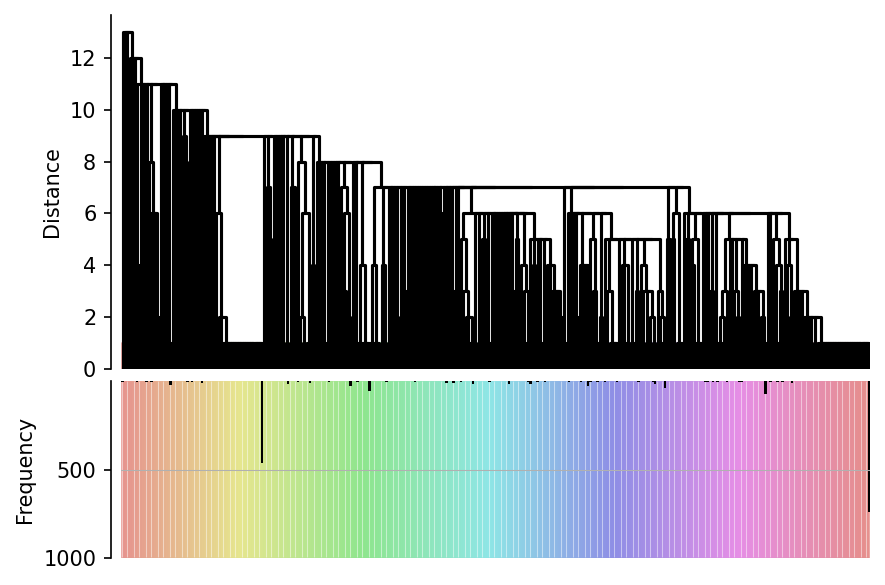

Finding allele frequencies from cluster indices
There are 5 clusters with [462, 58, 75, 739, 696]
['AG1000G-GH', 'AG1000G-ML-A', 'AG1000G-BF-A', 'AG1000G-BF-B', 'AG1000G-GN-A', 'AG1000G-GN-B', '1244-VO-GH-YAWSON-VMF00051', '1245-VO-CI-CONSTANT-VMF00054', '1253-VO-TG-DJOGBENOU-VMF00052', '1237-VO-BJ-DJOGBENOU-VMF00050'], query=aim_species == 'gambiae', cohort_size : 1015
Remapping haplotype alleles to match snp effect data...
Clustering genotypes


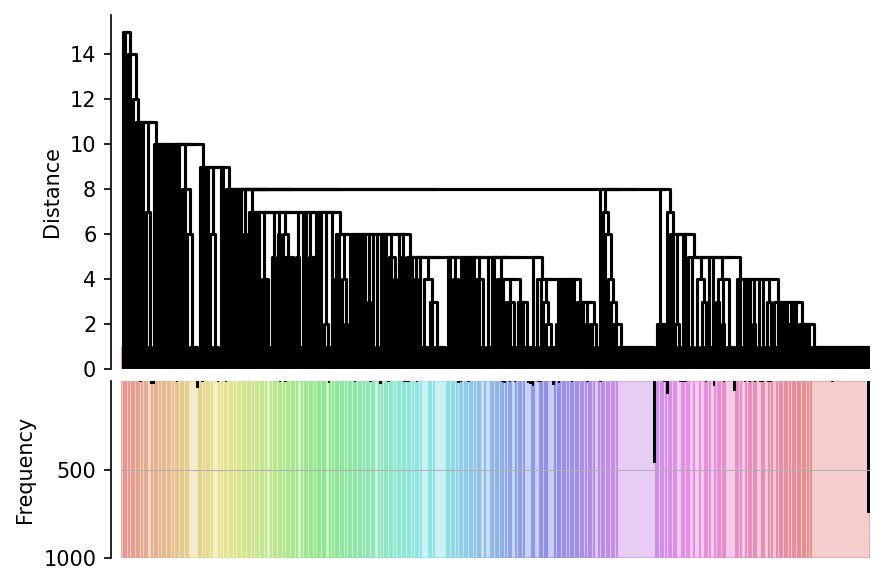

Finding allele frequencies from cluster indices
There are 5 clusters with [478, 76, 59, 776, 601]


In [11]:
snpdf_227, coho, leav = phase3cluster(cohorts, "AGAP006227-RA", contig, cut=1, t=0, min_cohort_size=40, metaquery="aim_species == 'gambiae'")
snpdf_228, coho2, leav = phase3cluster(cohorts, "AGAP006228-RA", contig, cut=1, t=0, min_cohort_size=40, metaquery="aim_species == 'gambiae'")

In [12]:
eff = pd.concat([snpdf_227.iloc[:,np.concatenate([np.arange(0,16), [21]])], snpdf_228.iloc[:,np.concatenate([np.arange(0,16), [21]])]], axis=0).query("max_af > 0.05 & effect == 'NON_SYNONYMOUS_CODING'")
aapos = eff['position'].unique()

In [13]:
aa_mask = pos[gene_bool].locate_intersection(aapos)[0]

In [83]:
haps = haps.compress(aa_mask, axis=0)

In [ ]:
# palette = sns.color_palette('nipy_spectral', n_colors=len(hap_labels) - 2, desat=0.8)
# # add a colour for other_resistant
# palette.append((0, 0, 0))
# # add a colour for wt 
# palette.append((0.9, 0.9, 0.9))
# # check
# sns.palplot(palette)
# plt.gca().set_xticklabels(hap_labels);

In [23]:
max_dist = 3       # dist that breaks edges; default is 5; CC uses 2 -> if network method is MJN, then it doesn't work for max_dist>1!!!!
max_alle = 1       # indirect variant breaks
net_meth = "msn"   # can be: minimum_spanning_network msn ; minimum_spanning_tree mst ; median_joining_network mjt
min_fq_h = 0.01   # min freq of the haplotype cluster, below that the component will be excluded from plots
min_fc_h = int(min_fq_h*haps.shape[1])

labels = np.repeat("", haps.shape[0]).astype("object")

labels[aa_mask] = eff['aa_change'].to_numpy()

import warnings
warnings.filterwarnings('ignore')

loc_graph, loc_distinct_sets, loc_components = graph_haplotype_network(
    h=haps,
    max_dist=max_dist,   
    max_allele=max_alle, # for MJN only; default is 3
    show_node_labels=min_fc_h,
    distance_metric='hamming',network_method=net_meth,
    hap_colors=None, variant_labels=labels,
    return_components=True,show_singletons=True)

num_components = loc_components.shape[0]

In [24]:
# map hap clusters with REF alleles to actual lists of populations
# BEWARE: identify_components fails if max_dist > 1 in MJN
def identify_components(h_distinct_sets, components):
    """This function is designed to collect all indices for original haplotypes 
    within each connected component. I.e., it finds clusters from the network."""
    clusters = []
    for c in np.unique(components):
        cluster = set()
        for i in np.nonzero(components == c)[0]:
            cluster |= h_distinct_sets[i]
        clusters.append(sorted(cluster))
    return clusters

loc_components_id      = identify_components(loc_distinct_sets, loc_components) 
loc_components_id_hapi = []
loc_components_id_clui = []
loc_components_id_dati = pd.DataFrame()
for n,i in enumerate(loc_components_id):
    loc_components_id_hapi = loc_components_id_hapi + loc_components_id[n]
    loc_components_id_clui = loc_components_id_clui + list([n]*len(loc_components_id[n]))

loc_components_id_dati["hap_index"]   = loc_components_id_hapi
loc_components_id_dati["hap_cluster"] = loc_components_id_clui
loc_components_id_dati                = loc_components_id_dati.sort_values(by="hap_index")
loc_components_id_dati                = loc_components_id_dati.set_index(keys="hap_index")
loc_components_id_dati["pop"]         = metahaps["country"].values
loc_components_id_dati["hap_id"]      = metahaps["sample_id"].values

# report
print("total haps:",haps.shape[1])
print("num haps per cluster (only clusters n>=%i):" % min_fc_h)
print(loc_components_id_dati.groupby(("hap_cluster")).size()[loc_components_id_dati.groupby(("hap_cluster")).size()>=min_fc_h])

total haps: 2030
num haps per cluster (only clusters n>=20):
hap_cluster
1       67
5      728
18     430
31      36
58      30
59      76
140     22
dtype: int64


In [28]:
min_cluster_size = min_fc_h
    
# select clusters
clu_list_ids     = np.unique(loc_components_id_dati["hap_cluster"],return_counts=True)[0]
clu_list_cou     = np.unique(loc_components_id_dati["hap_cluster"],return_counts=True)[1]
clu_list_ids_fil = clu_list_ids[clu_list_cou >= min_cluster_size]
clu_list_cou_fil = clu_list_cou[clu_list_cou >= min_cluster_size]
loc_printhap     = np.isin(loc_components_id_dati["hap_cluster"].values, clu_list_ids_fil)

print(loc_varn,loc_focus,"print clusters:", clu_list_ids_fil,"\t\tsize of clusters: ",clu_list_cou_fil)
print(loc_varn,loc_focus,"print clusters total size:",sum(loc_printhap),"/",len(loc_printhap))

E477V 28545767 print clusters: [  1   5  18  31  58  59 140] 		size of clusters:  [ 67 728 430  36  30  76  22]
E477V 28545767 print clusters total size: 1389 / 2030


In [40]:
l_nom = 'coeae1f'
chrom= '2L'
outdir ="./"
outcode = "coe_hapnet"

# plot pdf
loc_graph.format = 'pdf'
loc_graph.attr(label='\n\n%s %s %s:%i\n%i haps clustered into %i clusters with %s maxdist %i, from %i phased vars located +/- %i bp' % (l_nom,loc_varn,chrom,loc_focus,haps.shape[1],num_components,net_meth,max_dist,haps.shape[0],0))
fn = "%s/%s_%s.hn_%s_var_%s_%s-gtyvgsc_minfq" % (outdir,outcode,l_nom,net_meth,loc_focus,loc_varn)
loc_graph.render(fn,cleanup=True)

'coe_hapnet_coeae1f.hn_msn_var_28545767_E477V-gtyvgsc_minfq.pdf'